In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [10]:
len(features)

3159

In [11]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]

In [12]:
len(features)

309

## Model

In [13]:
#!pip install iterative-stratification

In [14]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from multiprocessing import cpu_count

In [15]:
class CFG:
  debug=False
  ver=34
  model="lightgbm"
  n_folds=8
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover"
  fold_target3="cover"

In [16]:
#features = list(features)
features.remove('id')
features.remove('area')
features.remove("year")
#features.remove("month")
features.append("mesh20")

In [17]:
# ========= GET CV =================
# https://blog.amedama.jp/entry/time-series-cv
import sys
from calendar import month_name

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


class MovingWindowKFold(TimeSeriesSplit):
    """時系列情報が含まれるカラムでソートした iloc を返す KFold"""

    def __init__(self, ts_column, clipping=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 時系列データのカラムの名前
        self.ts_column = ts_column
        # 得られる添字のリストの長さを過去最小の Fold に揃えるフラグ
        self.clipping = clipping

    def split(self, X, *args, **kwargs):
        # 渡されるデータは DataFrame を仮定する
        assert isinstance(X, pd.DataFrame)

        # clipping が有効なときの長さの初期値
        train_fold_min_len, test_fold_min_len = sys.maxsize, sys.maxsize

        # 時系列のカラムを取り出す
        ts = X[self.ts_column]
        # 元々のインデックスを振り直して iloc として使える値 (0, 1, 2...) にする
        ts_df = ts.reset_index()
        # 時系列でソートする
        sorted_ts_df = ts_df.sort_values(by=self.ts_column)
        # スーパークラスのメソッドで添字を計算する
        for train_index, test_index in super().split(sorted_ts_df, *args, **kwargs):
            # 添字を元々の DataFrame の iloc として使える値に変換する
            train_iloc_index = sorted_ts_df.iloc[train_index].index
            test_iloc_index = sorted_ts_df.iloc[test_index].index

            if self.clipping:
                # TimeSeriesSplit.split() で返される Fold の大きさが徐々に大きくなることを仮定している
                train_fold_min_len = min(train_fold_min_len, len(train_iloc_index))
                test_fold_min_len = min(test_fold_min_len, len(test_iloc_index))

            yield list(train_iloc_index[-train_fold_min_len:]), list(test_iloc_index[-test_fold_min_len:])

def ts_train_test_split(df, ts_column, **options):
    """時系列情報が含まれるカラムでソートした iloc を返す Hold-Out"""
    # シャッフルしない
    options['shuffle'] = False
    # 時系列のカラムを取り出す
    ts = df[ts_column]
    # 元々のインデックスを振り直して iloc として使える値 (0, 1, 2...) にする
    ts_df = ts.reset_index()
    # 時系列でソートする
    sorted_ts_df = ts_df.sort_values(by=ts_column)
    # 添字を計算する
    train_index, test_index = train_test_split(sorted_ts_df.index, **options)
    return list(train_index), list(test_index)

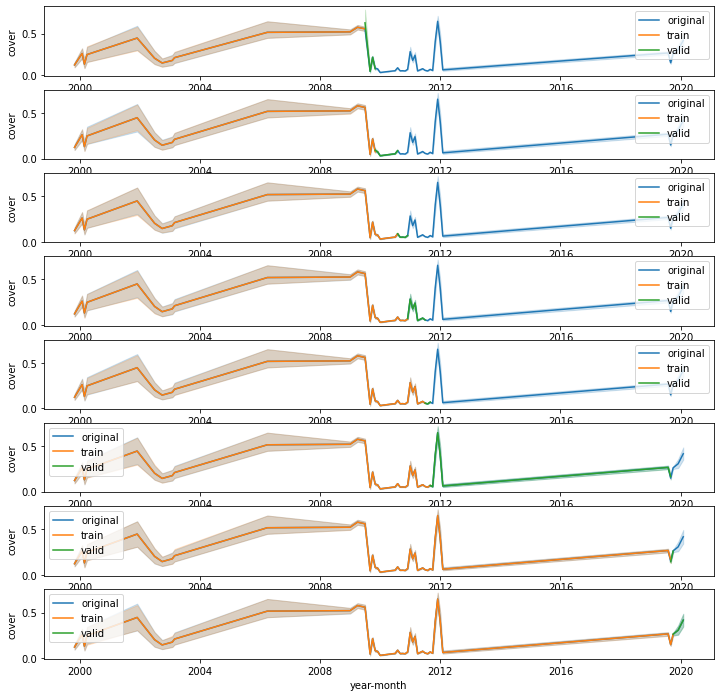

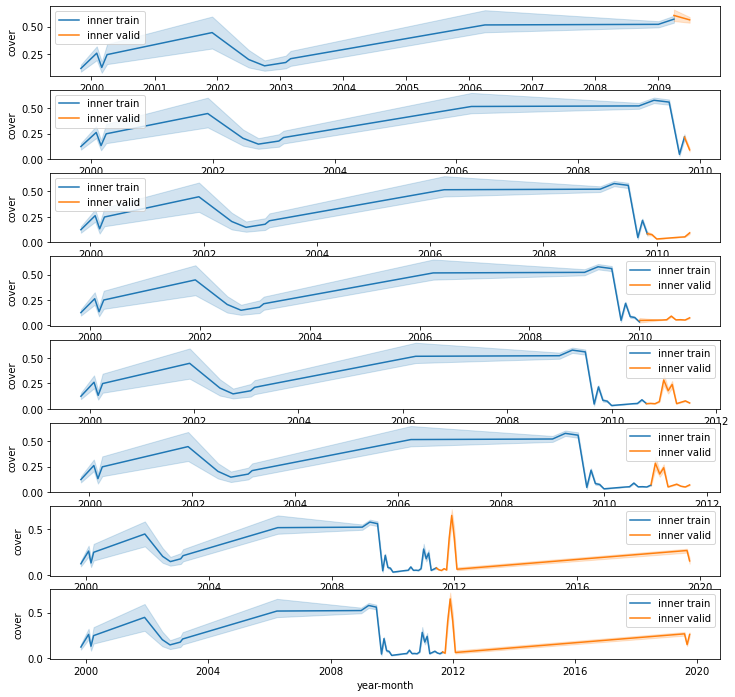

In [18]:
from sklearn.model_selection import TimeSeriesSplit

fig, axes = plt.subplots(CFG.n_folds, 1, figsize=(12, 12))
fig2, axes2 = plt.subplots(CFG.n_folds, 1, figsize=(12, 12))

train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)


outer_cv = MovingWindowKFold(ts_column='year-month', n_splits=CFG.n_folds)

for i, (train_index, test_index) in enumerate(outer_cv.split(train)):

    #print("="*15,f" OUTER CV FOLD{i} ","="*15)
    sns.lineplot(data=train, x='year-month', y='cover', ax=axes[i], label='original')
    # 学習用データを描く
    sns.lineplot(data=train.iloc[train_index], x='year-month', y='cover', ax=axes[i], label='train')
    # テスト用データを描く
    sns.lineplot(data=train.iloc[test_index], x='year-month', y='cover', ax=axes[i], label='valid')

    #print()
    #print("="*15," INNER CV ","="*15)
    inner_tr_idx, inner_va_idx = ts_train_test_split(train.iloc[train_index], ts_column='year-month', test_size=0.33)
    sns.lineplot(data=train.iloc[inner_tr_idx], x='year-month', y='cover', ax=axes2[i], label='inner train')
    sns.lineplot(data=train.iloc[inner_va_idx], x='year-month', y='cover', ax=axes2[i], label='inner valid')
    #print()



# グラフを表示する
plt.legend()
plt.show()

In [19]:
params = [{
        'objective': ['regression'],
        'metric': ['rmse'],
        'learning_rate': [0.1, 0.05],
        'boosting': [CFG.boosting_type, "dart"],
        'seed': [CFG.seed],
        "reg_alpha": [0.5],
        "reg_lambda": [0.5],
        "n_estimators": [1000],
        'min_child_weight': [1, 5],
        "max_depth": [3, 5, 7],
        "colsample_bytree": [0.4, 0.7, 1.0],
    }]

In [20]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

def rmse(y_true,y_pred):
    #RMSEを算出
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print('RMSE : ',rmse)
    return rmse

def get_pred(train, test, target_cols, model, candidate_params):
  X = train[features].values
  y = train[target_cols].values

  oof_df = pd.DataFrame()
  test_preds = np.zeros((len(test), CFG.n_folds))

  inner_cv = TimeSeriesSplit(n_splits=2)
  outer_cv = MovingWindowKFold(ts_column='year-month', n_splits=CFG.n_folds)
  clf = model
  for fold, (tr_index, va_index) in enumerate(outer_cv.split(train)):
    print("="*15,f" OUTER CV FOLD {fold} ","="*15)
    outer_train = train.iloc[tr_index]
    outer_valid = train.iloc[va_index]
    
    outer_train = outer_train.sort_values("year-month").reset_index(drop=True)

    outer_tr_X = outer_train[features].values
    outer_va_X = outer_valid[features].values
    test_X = test[features].values
    outer_tr_y = outer_train[target_cols].values
    outer_va_y = outer_valid[target_cols].values

    gs = GridSearchCV(estimator=clf,
                      param_grid=candidate_params,
                      cv=inner_cv,
                      scoring=make_scorer(mean_squared_error,greater_is_better=False),
                      return_train_score=True,
                      n_jobs=-1)
    gs.fit(outer_tr_X, outer_tr_y,
           eval_set=[(outer_va_X, outer_va_y)],
           early_stopping_rounds=50,
           verbose = 200)
    print('The best parameter = ', gs.best_params_)

    outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)
    oof_df = pd.concat([oof_df, outer_valid])

    print('RMSE = ',mean_squared_error(outer_va_y, outer_valid["pred"], squared=False))

    test_preds[:, fold] = gs.best_estimator_.predict(test_X)

  return oof_df, test_preds

In [21]:
%%time
if CFG.debug:
  print(train.shape)
  train = train.sample(n=500, random_state=CFG.seed).reset_index(drop=True)
  train.sort_values("year-month").reset_index(drop=True)
  print(train.shape)


model2 = lgb.LGBMRegressor()
oof_df, test_pred = get_pred(train, test, CFG.target_cols2, model2, params)

===============  OUTER CV FOLD 0  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.166593
[400]	valid_0's rmse: 0.168567
[600]	valid_0's rmse: 0.170496
[800]	valid_0's rmse: 0.16996
[1000]	valid_0's rmse: 0.170258
The best parameter =  {'boosting': 'dart', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-20-bab7f0e53b0c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.1702548156190883
===============  OUTER CV FOLD 1  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.161093
[400]	valid_0's rmse: 0.165917
[600]	valid_0's rmse: 0.158918
[800]	valid_0's rmse: 0.155238
[1000]	valid_0's rmse: 0.154292
The best parameter =  {'boosting': 'dart', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.154291256539715


<ipython-input-20-bab7f0e53b0c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 2  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.0820802
[400]	valid_0's rmse: 0.0853763
[600]	valid_0's rmse: 0.0872655
[800]	valid_0's rmse: 0.0897858
[1000]	valid_0's rmse: 0.0888693
The best parameter =  {'boosting': 'dart', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-20-bab7f0e53b0c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.0888694817346836
===============  OUTER CV FOLD 3  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.146955
[400]	valid_0's rmse: 0.141067
[600]	valid_0's rmse: 0.13936
[800]	valid_0's rmse: 0.138247
[1000]	valid_0's rmse: 0.137987
The best parameter =  {'boosting': 'dart', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-20-bab7f0e53b0c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.13798738147715153
===============  OUTER CV FOLD 4  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.125411
[400]	valid_0's rmse: 0.136266
[600]	valid_0's rmse: 0.13924
[800]	valid_0's rmse: 0.14177
[1000]	valid_0's rmse: 0.142733
The best parameter =  {'boosting': 'dart', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}
RMSE =  0.14273334067254007


<ipython-input-20-bab7f0e53b0c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)


===============  OUTER CV FOLD 5  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.22744
[400]	valid_0's rmse: 0.222648
[600]	valid_0's rmse: 0.220144
[800]	valid_0's rmse: 0.224339
[1000]	valid_0's rmse: 0.223297
The best parameter =  {'boosting': 'dart', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-20-bab7f0e53b0c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.22329734294440662
===============  OUTER CV FOLD 6  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.246507
[400]	valid_0's rmse: 0.241859
[600]	valid_0's rmse: 0.24132
[800]	valid_0's rmse: 0.239057
[1000]	valid_0's rmse: 0.239454
The best parameter =  {'boosting': 'dart', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-20-bab7f0e53b0c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.2394536489135746
===============  OUTER CV FOLD 7  ===============


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.214957
[400]	valid_0's rmse: 0.205713
[600]	valid_0's rmse: 0.202166
[800]	valid_0's rmse: 0.200168
[1000]	valid_0's rmse: 0.198765
The best parameter =  {'boosting': 'dart', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 7, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'seed': 42}


<ipython-input-20-bab7f0e53b0c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)


RMSE =  0.19876497207906824
CPU times: user 24min 51s, sys: 28 s, total: 25min 19s
Wall time: 6h 36min 20s


In [22]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
rmse(_oof["cover"], _oof["pred"])

RMSE :  0.17564335547794865


0.17564335547794865

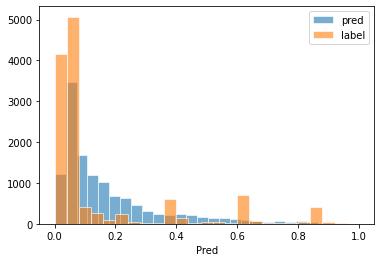

In [23]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [24]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,0.024123
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,0.128468
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,0.072996
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,0.074207
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,0.432288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.260930,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,0.111404
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.286240,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,0.084959
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.316359,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,0.308121
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.302570,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,0.143149


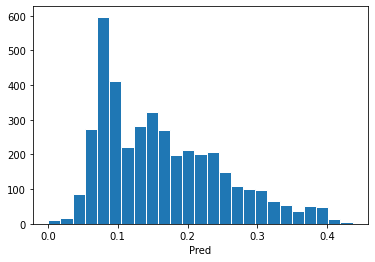

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,0.024123
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,0.128468
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,0.072996
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,0.074207
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,0.432288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.260930,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,0.111404
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.286240,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,0.084959
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.316359,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,0.308121
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.302570,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,0.143149


In [25]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)